In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


In [2]:
# Step 1: Imports
import pandas as pd
import numpy as np

# Step 2: Load the data
train = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e6/sample_submission.csv')
# Step 3: Explore the data
print(train.head())
print(train['Fertilizer Name'].value_counts())

# Step 4: Dummy model (predict most frequent fertilizers)
top3_fertilizers = train['Fertilizer Name'].value_counts().head(3).index.tolist()
print("Top 3 fertilizers:", top3_fertilizers)

# Step 5: Create submission
test['Fertilizer Name'] = ' '.join(top3_fertilizers)
test[['id', 'Fertilizer Name']].to_csv('submission.csv', index=False)


   id  Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  \
0   0           37        70        36    Clayey  Sugarcane        36   
1   1           27        69        65     Sandy    Millets        30   
2   2           29        63        32     Sandy    Millets        24   
3   3           35        62        54     Sandy     Barley        39   
4   4           35        58        43       Red      Paddy        37   

   Potassium  Phosphorous Fertilizer Name  
0          4            5           28-28  
1          6           18           28-28  
2         12           16        17-17-17  
3         12            4        10-26-26  
4          2           16             DAP  
Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64
Top 3 fertilizers: ['14-35-14', '10-26-26', '17-17-17']


In [3]:
# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import label_ranking_average_precision_score

# Step 2: Load the data
train = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e6/sample_submission.csv')

# Step 3: Preprocess
target = 'Fertilizer Name'

# Label encode target
le = LabelEncoder()
train[target] = le.fit_transform(train[target])

# Store label mapping
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

# Drop ID and target from training features
X = train.drop(columns=['id', target])
y = train[target]

# Align test data
X_test = test.drop(columns=['id'])

# Handle categorical variables if any
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

# Step 4: Train model
model = LGBMClassifier(n_estimators=200, random_state=42)
model.fit(X, y)

# Step 5: Predict top 3 probabilities
probs = model.predict_proba(X_test)
top3_preds = np.argsort(probs, axis=1)[:, -3:][:, ::-1]  # Top 3 in descending order

# Step 6: Convert predictions to label names
pred_labels = le.inverse_transform(top3_preds.ravel()).reshape(top3_preds.shape)
submission = test[['id']].copy()
submission['Fertilizer Name'] = [' '.join(row) for row in pred_labels]

# Step 7: Save submission
submission.to_csv('submission.csv', index=False)
print("✅ Submission file created!")

# Step 8: (Optional) Local MAP@3 Evaluation
def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        score = 0.0
        cnt = 0.0
        for i in range(k):
            if p[i] in a and p[i] not in p[:i]:  # no repeat credit
                cnt += 1
                score += cnt / (i + 1.0)
        return score / min(len(a), k)

    return np.mean([apk([a], p, k) for a, p in zip(actual, predicted)])

# (Optional) local validation
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# model.fit(X_train, y_train)
# val_probs = model.predict_proba(X_val)
# val_top3 = np.argsort(val_probs, axis=1)[:, -3:][:, ::-1]
# score = mapk(y_val.values, val_top3)
# print(f"Local MAP@3: {score:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 22
[LightGBM] [Info] Start training from score -1.884866
[LightGBM] [Info] Start training from score -1.880057
[LightGBM] [Info] Start training from score -1.897538
[LightGBM] [Info] Start training from score -1.911544
[LightGBM] [Info] Start training from score -1.909121
[LightGBM] [Info] Start training from score -2.067671
[LightGBM] [Info] Start training from score -2.094845
✅ Submission file created!


In [4]:
 #(Optional) local validation
 X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
 model.fit(X_train, y_train)
 val_probs = model.predict_proba(X_val)
 val_top3 = np.argsort(val_probs, axis=1)[:, -3:][:, ::-1]
 score = mapk(y_val.values, val_top3)
 print(f"Local MAP@3: {score:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 22
[LightGBM] [Info] Start training from score -1.885565
[LightGBM] [Info] Start training from score -1.877350
[LightGBM] [Info] Start training from score -1.900582
[LightGBM] [Info] Start training from score -1.909654
[LightGBM] [Info] Start training from score -1.910836
[LightGBM] [Info] Start training from score -2.069993
[LightGBM] [Info] Start training from score -2.091474
Local MAP@3: 0.3266


In [5]:
submission.to_csv('submission.csv', index=False)
print("✅ Submission file created!")

✅ Submission file created!


In [6]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')

# Encode the target
le = LabelEncoder()
train['Fertilizer Name'] = le.fit_transform(train['Fertilizer Name'])
target = 'Fertilizer Name'
id_col = 'id'


In [7]:
# Features
X = train.drop(columns=[id_col, target])
y = train[target]
X_test = test.drop(columns=[id_col])

# Categorical features
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# CV setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((X.shape[0], len(np.unique(y))))
test_preds = np.zeros((X_test.shape[0], len(np.unique(y))))

In [8]:
# Train + CV
for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        eval_metric='Accuracy',
        random_seed=42,
        verbose=0
    )

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)
    test_pool = Pool(X_test, cat_features=cat_features)

    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

    oof_preds[val_idx] = model.predict_proba(X_val)
    test_preds += model.predict_proba(X_test) / kf.n_splits

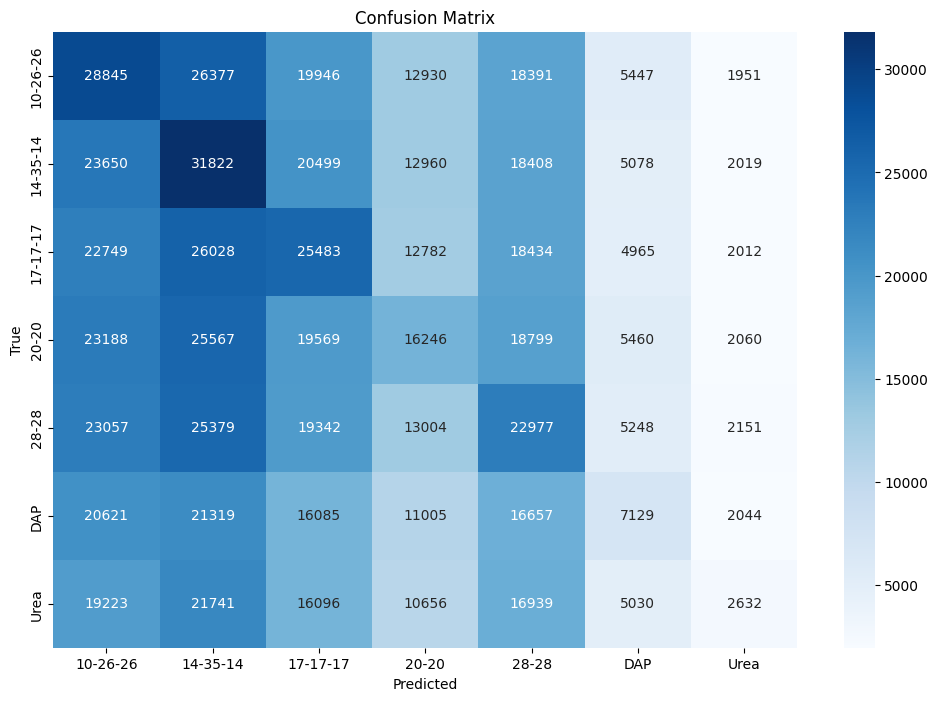

✅ Submission saved as 'submission.csv'
              precision    recall  f1-score   support

    10-26-26       0.18      0.25      0.21    113887
    14-35-14       0.18      0.28      0.22    114436
    17-17-17       0.19      0.23      0.20    112453
       20-20       0.18      0.15      0.16    110889
       28-28       0.18      0.21      0.19    111158
         DAP       0.19      0.08      0.11     94860
        Urea       0.18      0.03      0.05     92317

    accuracy                           0.18    750000
   macro avg       0.18      0.17      0.16    750000
weighted avg       0.18      0.18      0.17    750000



In [9]:
# Final predictions
final_preds = np.argmax(oof_preds, axis=1)

# Confusion matrix
cm = confusion_matrix(y, final_preds)
report = classification_report(y, final_preds, target_names=le.classes_)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Submission: get top 3
top3 = np.argsort(test_preds, axis=1)[:, -3:][:, ::-1]
top3_labels = le.inverse_transform(top3.ravel()).reshape(top3.shape)
submission = test[[id_col]].copy()
submission['Fertilizer Name'] = [' '.join(row) for row in top3_labels]
submission.to_csv('submission.csv', index=False)

print("✅ Submission saved as 'submission.csv'")
print(report)
